In [246]:
!pip install emoji

In [248]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv, os

from sklearn import preprocessing
from collections import Counter
from math import ceil
from sklearn.metrics import mean_absolute_error as MAE

import re
from string import punctuation
from emoji import UNICODE_EMOJI

In [239]:
### Loading dataset

path = os.getcwd()
path_data_train = path + "\\covidChallenge\\data\\train.csv"

df = pd.read_csv(path_data_train)

### Generating more features for CatRegressor 

In [242]:

def clean_texts(df):
    # remove URL
    df['text_proc'] = df['text'].str.replace(r'http(\S)+', r'')
    df['text_proc'].fillna('', inplace=True)
    df['text_proc'] = df['text_proc'].str.replace(r'http ...', r'')
    df['text_proc'] = df['text_proc'].str.replace(r'http', r'')

    # remove RT, @
    df['text_proc'] = df['text_proc'].str.replace(r'(RT|rt)[ ]*@[ ]*[\S]+', r'')
    df['text_proc'] = df['text_proc'].str.replace(r'@[\S]+', r'')

    # remove non-ascii words and characters
    df['text_proc'] = [''.join([i if ord(i) < 128 else '' for i in text]) for text in df['text_proc'].values]
    df['text_proc'] = df['text_proc'].str.replace(r'_[\S]?', r'')

    # remove &, < and >
    df['text_proc'] = df['text_proc'].str.replace(r'&amp;?', r'and')
    df['text_proc'] = df['text_proc'].str.replace(r'&lt;', r'<')
    df['text_proc'] = df['text_proc'].str.replace(r'&gt;', r'>')

    # remove extra space
    df['text_proc'] = df['text_proc'].str.replace(r'[ ]{2, }', r' ')

    # insert space between punctuation marks
    df['text_proc'] = df['text_proc'].str.replace(r'([\w\d]+)([^\w\d ]+)', r'\1 \2')
    df['text_proc'] = df['text_proc'].str.replace(r'([^\w\d ]+)([\w\d]+)', r'\1 \2')

    # lower case and strip white spaces at both ends
    df['text_proc'] = df['text_proc'].str.lower()
    df['text_proc'] = df['text_proc'].str.strip()
    return df


def add_text_features(df_):
    df = df_.copy()
    df = clean_texts(df)
    df['text'].fillna('', inplace=True)
    df['text_length'] = df['text'].str.len()
    df['text_proc_length'] = df['text_proc'].str.len()
    df['text_proc_length_to_text_length'] = df['text_proc_length'] / df['text_length']
    df['text_lines_count'] = df['text'].str.count('\n')
    df['text_word_count'] = df['text'].str.split().apply(len)
    df['text_proc_word_count'] = df['text_proc'].str.split().apply(len)
    df['text_proc_word_count_to_text_word_count'] = df['text_proc_word_count'] / df['text_word_count']
    df['text_mean_word_length'] = df['text'].str.split().apply(lambda arr: np.mean([len(word) for word in arr]))
    df['text_proc_mean_word_length'] = df['text_proc'].str.split().apply(lambda arr: np.mean([len(word) for word in arr]))
    df['text_proc_mean_word_length_to_text_mean_word_length'] = df['text_proc_mean_word_length'] / df['text_mean_word_length']
    df['text_proc_alphas_count'] = df['text_proc'].apply(lambda s: sum(c.isalpha() for c in s))
    df['text_alphas_count'] = df['text'].apply(lambda s: sum(c.isalpha() for c in s))
    df['text_proc_alphas_count_to_text_alphas_count'] = df['text_proc_alphas_count'] / df['text_alphas_count']
    df['text_alphas_percent'] = df['text_alphas_count'] / df['text_length']
    df['text_non_alphas_count'] = df['text'].apply(lambda s: sum(not c.isalpha() for c in s))
    df['text_digits_count'] = df['text'].apply(lambda s: sum(c.isdigit() for c in s))
    df['text_digits_count'] = df['text'].apply(lambda s: sum(c.isdigit() for c in s))
    df['text_emoji_count'] = df['text'].apply(lambda s: sum(c in UNICODE_EMOJI for c in s))
    df['text_emoji_percent'] = df['text_emoji_count'] / df['text_length']
    df['text_has_emoji'] = (df['text_emoji_count'] > 0).astype(int)
    df['text_upper_letter_count'] = df['text'].apply(lambda s: sum(1 for c in s if c.isupper()))
    df['text_upper_letter_count_to_word_count'] = df['text_upper_letter_count'] / df['text_word_count']
    df['text_upper_letter_count_to_length'] = df['text_upper_letter_count'] / df['text_length']
    df['text_urls_count'] = df['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
    df['text_urls_count_to_words_count'] = df['text_urls_count'] / df['text_word_count']
    df['text_hashtags_count'] = df['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
    df['text_hashtags_count_to_words_count'] = df['text_hashtags_count'] / df['text_word_count']
    df['text_usertag_count'] = df['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))
    df['text_usertags_count_to_words_count'] = df['text_usertag_count'] / df['text_word_count']
    df['text_punctuation_count'] = df['text'].apply(lambda s: sum(1 for c in s if c in punctuation))
    df['text_proc_punctuation_count'] = df['text_proc'].apply(lambda s: sum(1 for c in s if c in punctuation))
    df['text_punctuation_rate'] = df['text_punctuation_count'] / df['text_length']
    df['text_punctuation_to_alpha'] = df['text_punctuation_count'] / df['text_alphas_count']
    df['text_proc_punctuation_to_alpha'] = df['text_proc_punctuation_count'] / df['text_proc_alphas_count']
    df['text_punctuation_unique_count'] = df['text'].apply(lambda s: len(set([c for c in s if c in punctuation])))
    df['text_proc_count_!'] = df['text_proc'].apply(lambda s: sum(c == '!' for c in s))
    df['text_proc_count_?'] = df['text_proc'].apply(lambda s: sum(c == '?' for c in s))

    return df

In [4]:
def encode(s, word):
    try:
        if word in s.lower():
            return 1
        else:
            return 0
    except:
        # print(s)
        return 0

def simple_encoder(df_, list_):
    df = df_.copy()
    for word in list_:
        df[word] = df['text'].apply(lambda s: encode(s, word))
    return df

listik_ = ['fuck', 'shit', 't.co', 'covid', 'coronavirus']

df_train_encode = simple_encoder(df, listik_)
df_train_encode.head()

id      timestamp  retweet_count  user_verified  user_statuses_count  \
0   0  1588696955143              0          False                68460   
1   1  1588464948124              0          False                  309   
2   2  1588634673360              0          False                 3241   
3   3  1588433158672              0          False                32327   
4   4  1588582751599              0          False                  581   

   user_followers_count  user_friends_count user_mentions urls hashtags  \
0                  1101                1226           NaN  NaN      NaN   
1                    51                 202           NaN  NaN      NaN   
2                  1675                2325           NaN  NaN      NaN   
3                   667                 304           NaN  NaN      NaN   
4                    42                 127           NaN  NaN      NaN   

                                                text  fuck  shit  t.co  covid  \
0                                      Smh I give up     0     0     0      0   
1  Most of us are Human Beings, but I think you m...     0     0     0      0   
2  Old dirty tricks Trump, at it again...like we ...     0     0     0      0   
3  Seriously..... I worked 86 hours my last check...     0     0     0      0   
4  May ALMIGHTY ALLAH have mercy on us all. Only ...     0     0     0      0   

   coronavirus  
0            0  
1            0  
2            0  
3            0  
4            0

In [5]:
df_train_encode

id      timestamp  retweet_count  user_verified  \
0            0  1588696955143              0          False   
1            1  1588464948124              0          False   
2            2  1588634673360              0          False   
3            3  1588433158672              0          False   
4            4  1588582751599              0          False   
...        ...            ...            ...            ...   
665772  665772  1588412684317              0          False   
665773  665773  1588324521711              1          False   
665774  665774  1588353174952              8          False   
665775  665775  1588691378352              0          False   
665776  665776  1588432578764              0          False   

        user_statuses_count  user_followers_count  user_friends_count  \
0                     68460                  1101                1226   
1                       309                    51                 202   
2                      3241                  1675                2325   
3                     32327                   667                 304   
4                       581                    42                 127   
...                     ...                   ...                 ...   
665772                65355                  1984                1902   
665773                 1807                  2029                 347   
665774                  888                    85                 257   
665775                  452                    38                  91   
665776                  590                   184                 238   

       user_mentions                         urls hashtags  \
0                NaN                          NaN      NaN   
1                NaN                          NaN      NaN   
2                NaN                          NaN      NaN   
3                NaN                          NaN      NaN   
4                NaN                          NaN      NaN   
...              ...                          ...      ...   
665772           NaN                          NaN      NaN   
665773  StanfordEMED  twitter.com/i/web/status/1…  COVID19   
665774           NaN  twitter.com/i/web/status/1…      NaN   
665775           NaN                          NaN      NaN   
665776           NaN                          NaN      NaN   

                                                     text  fuck  shit  t.co  \
0                                           Smh I give up     0     0     0   
1       Most of us are Human Beings, but I think you m...     0     0     0   
2       Old dirty tricks Trump, at it again...like we ...     0     0     0   
3       Seriously..... I worked 86 hours my last check...     0     0     0   
4       May ALMIGHTY ALLAH have mercy on us all. Only ...     0     0     0   
...                                                   ...   ...   ...   ...   
665772                     18 months dawg? Come on man...     0     0     0   
665773  Thank you to all of the nurses in our @Stanfor...     0     0     1   
665774  'Post it' pearls for Palliative, End of Life a...     0     0     1   
665775  His facial expressions are kind of looking for...     0     0     0   
665776                              We really can't wait.     0     0     0   

        covid  coronavirus  
0           0            0  
1           0            0  
2           0            0  
3           0            0  
4           0            0  
...       ...          ...  
665772      0            0  
665773      1            0  
665774      1            0  
665775      0            0  
665776      0            0  

[665777 rows x 16 columns]

In [6]:
df_train_text = add_text_features(df_train_encode)

C:\Users\Imadeddine\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


In [7]:
df_train_text.to_csv("train_morefeature_text.csv")

In [ ]:
### To prevent clearning process (too long)

In [83]:
df_train_text = pd.read_csv("train_morefeature_text.csv")

In [85]:
df_train_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665777 entries, 0 to 665776
Data columns (total 54 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   Unnamed: 0                                           665777 non-null  int64  
 1   id                                                   665777 non-null  int64  
 2   timestamp                                            665777 non-null  int64  
 3   retweet_count                                        665777 non-null  int64  
 4   user_verified                                        665777 non-null  bool   
 5   user_statuses_count                                  665777 non-null  int64  
 6   user_followers_count                                 665777 non-null  int64  
 7   user_friends_count                                   665777 non-null  int64  
 8   user_mentions                                        5

In [86]:
df_train_text['urls'] = df_train_text['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
df_train_text['hashtags'] = df_train_text['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
df_train_text['user_mentions'] = df_train_text['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))

In [87]:
df_train_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665777 entries, 0 to 665776
Data columns (total 54 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   Unnamed: 0                                           665777 non-null  int64  
 1   id                                                   665777 non-null  int64  
 2   timestamp                                            665777 non-null  int64  
 3   retweet_count                                        665777 non-null  int64  
 4   user_verified                                        665777 non-null  bool   
 5   user_statuses_count                                  665777 non-null  int64  
 6   user_followers_count                                 665777 non-null  int64  
 7   user_friends_count                                   665777 non-null  int64  
 8   user_mentions                                        6

In [88]:
### Clean the missing values
df_train_text.dropna(inplace=True)
df_train_text.reset_index(drop=True,inplace=True)
df_train_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664197 entries, 0 to 664196
Data columns (total 54 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   Unnamed: 0                                           664197 non-null  int64  
 1   id                                                   664197 non-null  int64  
 2   timestamp                                            664197 non-null  int64  
 3   retweet_count                                        664197 non-null  int64  
 4   user_verified                                        664197 non-null  bool   
 5   user_statuses_count                                  664197 non-null  int64  
 6   user_followers_count                                 664197 non-null  int64  
 7   user_friends_count                                   664197 non-null  int64  
 8   user_mentions                                        6

In [89]:
df_train_text.drop('id', axis=1, inplace=True)
df_train_text.drop('timestamp', axis=1, inplace=True)
df_train_text.drop('text_proc', axis=1, inplace=True)
df_train_text.drop('text', axis=1, inplace=True)
df_train_text.drop('Unnamed: 0', axis=1, inplace=True)

In [78]:
#df_train_text.drop('text_proc', axis=1, inplace=True)

In [79]:
#df_train_text.drop('user_mentions', axis=1, inplace=True)

In [90]:
df_train_text = df_train_text.astype(float)

In [91]:
#### Splitting dataset
from verstack.stratified_continuous_split import scsplit # pip install verstack

X_train, X_test, y_train, y_test = scsplit(df_train_text, df_train_text['retweet_count'], stratify=df_train_text['retweet_count'], train_size=0.7, test_size=0.3)

# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweet_count'], axis=1)
X_test = X_test.drop(['retweet_count'], axis=1)

In [92]:
### To use later for XGB Boost
xgbcopy_train = X_train.copy()

In [93]:
print("\t Train dataset shape: ", X_train.shape)
print("\t Test dataset shape: ", X_test.shape)

	 Train dataset shape:  (464937, 48)
	 Test dataset shape:  (199260, 48)


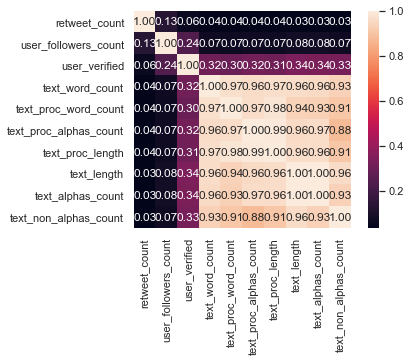

In [94]:
correlation = df_train_text.corr(method='pearson')
columns = correlation.nlargest(10, 'retweet_count').index

correlation_map = np.corrcoef(df_train_text[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

- Parameters taken from Cat Regressor notebook after doing gridSearch

In [109]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

model1 = CatBoostRegressor(iterations=3000, verbose = 1, task_type="GPU", devices='0', depth = 14, l2_leaf_reg = 1, learning_rate= 0.01)

In [110]:
model1.fit(X_train, y_train)

0:	learn: 2862.2045135	total: 316ms	remaining: 15m 47s
1:	learn: 2862.1040466	total: 348ms	remaining: 8m 41s
2:	learn: 2861.2370284	total: 627ms	remaining: 10m 26s
3:	learn: 2861.1389909	total: 657ms	remaining: 8m 11s
4:	learn: 2860.2121482	total: 937ms	remaining: 9m 21s
5:	learn: 2860.1161454	total: 969ms	remaining: 8m 3s
6:	learn: 2858.9224454	total: 1.25s	remaining: 8m 54s
7:	learn: 2858.8316257	total: 1.28s	remaining: 8m
8:	learn: 2858.2104049	total: 1.56s	remaining: 8m 38s
9:	learn: 2858.1213380	total: 1.59s	remaining: 7m 55s
10:	learn: 2857.0705735	total: 1.88s	remaining: 8m 31s
11:	learn: 2856.9861089	total: 1.91s	remaining: 7m 56s
12:	learn: 2856.0984869	total: 2.2s	remaining: 8m 24s
13:	learn: 2856.0164612	total: 2.23s	remaining: 7m 55s
14:	learn: 2854.9581087	total: 2.5s	remaining: 8m 17s
15:	learn: 2854.8796051	total: 2.53s	remaining: 7m 52s
16:	learn: 2852.8813338	total: 2.81s	remaining: 8m 12s
17:	learn: 2852.8060342	total: 2.84s	remaining: 7m 50s
18:	learn: 2852.0444278	t

In [111]:
print("Score on Training data: ", model1.score(X_train, y_train))

Score on Training data:  0.42876251619661965


In [112]:
ypred = model1.predict(X_test)

In [113]:
print("\t Prediction error using MSE: ", mean_squared_error(y_true=y_test, y_pred=ypred))
print("\t Prediction error using MAE: ", mean_absolute_error(y_true=y_test, y_pred=ypred))

	 Prediction error using MSE:  7714763.729837966
	 Prediction error using MAE:  234.14784544677752


## XGBoost regressor with only numerical features (non-categorical)

In [114]:
xgbcopy_train

user_verified  user_statuses_count  user_followers_count  \
359548            1.0              64813.0              177655.0   
601834            1.0              72807.0                9969.0   
465871            0.0                929.0                 101.0   
45431             0.0             100491.0               28871.0   
646446            0.0              16186.0               69002.0   
...               ...                  ...                   ...   
53579             0.0                 20.0                  69.0   
269490            0.0               1057.0                  65.0   
491197            0.0               5013.0                 973.0   
8052              0.0              14638.0                6819.0   
66284             1.0              32300.0              119655.0   

        user_friends_count  user_mentions  urls  hashtags  fuck  shit  t.co  \
359548                 0.0            0.0   0.0       1.0   0.0   0.0   0.0   
601834              5099.0            0.0   0.0       0.0   0.0   0.0   0.0   
465871               175.0            0.0   1.0       0.0   0.0   0.0   1.0   
45431              23759.0            0.0   1.0       0.0   0.0   0.0   1.0   
646446              9816.0            0.0   0.0       3.0   0.0   0.0   0.0   
...                    ...            ...   ...       ...   ...   ...   ...   
53579                234.0            0.0   0.0       0.0   0.0   0.0   0.0   
269490               259.0            0.0   0.0       0.0   0.0   0.0   0.0   
491197              3847.0            0.0   0.0       0.0   0.0   0.0   0.0   
8052                2726.0            0.0   1.0       4.0   0.0   0.0   1.0   
66284               1484.0            1.0   0.0       1.0   0.0   0.0   0.0   

        ...  text_usertag_count  text_usertags_count_to_words_count  \
359548  ...                 0.0                            0.000000   
601834  ...                 0.0                            0.000000   
465871  ...                 0.0                            0.000000   
45431   ...                 0.0                            0.000000   
646446  ...                 0.0                            0.000000   
...     ...                 ...                                 ...   
53579   ...                 0.0                            0.000000   
269490  ...                 0.0                            0.000000   
491197  ...                 0.0                            0.000000   
8052    ...                 0.0                            0.000000   
66284   ...                 1.0                            0.021739   

        text_punctuation_count  text_proc_punctuation_count  \
359548                     2.0                          2.0   
601834                     1.0                          1.0   
465871                     9.0                          4.0   
45431                      7.0                          2.0   
646446                    16.0                         13.0   
...                        ...                          ...   
53579                      0.0                          0.0   
269490                     5.0                          5.0   
491197                     0.0                          0.0   
8052                      11.0                          6.0   
66284                      9.0                          8.0   

        text_punctuation_rate  text_punctuation_to_alpha  \
359548               0.011429                   0.014286   
601834               0.032258                   0.040000   
465871               0.163636                   0.236842   
45431                0.036458                   0.044304   
646446               0.066946                   0.092486   
...                       ...                        ...   
53579                0.000000                   0.000000   
269490               0.056818                   0.079365   
491197               0.000000                   0.000000   
8052                 0.043478   

In [115]:
xgbcopy_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464937 entries, 359548 to 66284
Data columns (total 48 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   user_verified                                        464937 non-null  float64
 1   user_statuses_count                                  464937 non-null  float64
 2   user_followers_count                                 464937 non-null  float64
 3   user_friends_count                                   464937 non-null  float64
 4   user_mentions                                        464937 non-null  float64
 5   urls                                                 464937 non-null  float64
 6   hashtags                                             464937 non-null  float64
 7   fuck                                                 464937 non-null  float64
 8   shit                                              

In [117]:
xgbcopy_train.drop('shit', axis=1, inplace=True)
xgbcopy_train.drop('t.co', axis=1, inplace=True)
xgbcopy_train.drop('covid', axis=1, inplace=True)
xgbcopy_train.drop('coronavirus', axis=1, inplace=True)
xgbcopy_train.drop('user_verified', axis=1, inplace=True)

In [120]:
xgbcopy_train.drop('fuck', axis=1, inplace=True)

In [121]:
xgbcopy_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464937 entries, 359548 to 66284
Data columns (total 42 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   user_statuses_count                                  464937 non-null  float64
 1   user_followers_count                                 464937 non-null  float64
 2   user_friends_count                                   464937 non-null  float64
 3   user_mentions                                        464937 non-null  float64
 4   urls                                                 464937 non-null  float64
 5   hashtags                                             464937 non-null  float64
 6   text_length                                          464937 non-null  float64
 7   text_proc_length                                     464937 non-null  float64
 8   text_proc_length_to_text_length                   

In [122]:
xgbcopy_train

user_statuses_count  user_followers_count  user_friends_count  \
359548              64813.0              177655.0                 0.0   
601834              72807.0                9969.0              5099.0   
465871                929.0                 101.0               175.0   
45431              100491.0               28871.0             23759.0   
646446              16186.0               69002.0              9816.0   
...                     ...                   ...                 ...   
53579                  20.0                  69.0               234.0   
269490               1057.0                  65.0               259.0   
491197               5013.0                 973.0              3847.0   
8052                14638.0                6819.0              2726.0   
66284               32300.0              119655.0              1484.0   

        user_mentions  urls  hashtags  text_length  text_proc_length  \
359548            0.0   0.0       1.0        175.0             176.0   
601834            0.0   0.0       0.0         31.0              32.0   
465871            0.0   1.0       0.0         55.0              35.0   
45431             0.0   1.0       0.0        192.0             172.0   
646446            0.0   0.0       3.0        239.0             245.0   
...               ...   ...       ...          ...               ...   
53579             0.0   0.0       0.0         65.0              65.0   
269490            0.0   0.0       0.0         88.0              93.0   
491197            0.0   0.0       0.0         12.0              12.0   
8052              0.0   1.0       4.0        253.0             237.0   
66284             1.0   0.0       1.0        277.0             269.0   

        text_proc_length_to_text_length  text_lines_count  ...  \
359548                         1.005714               0.0  ...   
601834                         1.032258               0.0  ...   
465871                         0.636364               0.0  ...   
45431                          0.895833               0.0  ...   
646446                         1.025105              12.0  ...   
...                                 ...               ...  ...   
53579                          1.000000               1.0  ...   
269490                         1.056818               0.0  ...   
491197                         1.000000               0.0  ...   
8052                           0.936759               2.0  ...   
66284                          0.971119               5.0  ...   

        text_usertag_count  text_usertags_count_to_words_count  \
359548                 0.0                            0.000000   
601834                 0.0                            0.000000   
465871                 0.0                            0.000000   
45431                  0.0                            0.000000   
646446                 0.0                            0.000000   
...                    ...                                 ...   
53579                  0.0                            0.000000   
269490                 0.0                            0.000000   
491197                 0.0                            0.000000   
8052                   0.0                            0.000000   
66284                  1.0                            0.021739   

        text_punctuation_count  text_proc_punctuation_count  \
359548                     2.0                          2.0   
601834                     1.0                          1.0   
465871                     9.0                          4.0   
45431                      7.0                          2.0   
646446                    16.0                         13.0   
...                        ...                          ...   
53579                      0.0                          0.0   
269490                     5.0                          5.0   
491197                     0.0                          0.0   
8052                      11.0                    

In [55]:
import xgboost as xgb

model4 = xgb.XGBRegressor(tree_method='gpu_hist',
                                    colsample_bylevel=0.9,
                                    colsample_bynode=0.9,
                                    learning_rate=0.001,
                                    max_depth=25,
                                    max_leaves=25,
                                    n_estimators=3000,
                                    n_gpus = 1)

In [123]:
model4.fit(xgbcopy_train, y_train)

[15:55:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\include\xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.
[16:00:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\include\xgboost/generic_parameters.h:35: 
n_gpus: 
	Deprecated. Single process multi-GPU training is no longer supported.
	Please switch to distributed training with one process per GPU.
	This can be done using Dask or Spark.  See documentation for details.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.9,
             colsample_bynode=0.9, colsample_bytree=1, gamma=0, gpu_id=0,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.001, max_delta_step=0, max_depth=25, max_leaves=25,
             min_child_weight=1, missing=nan,
             monotone_constraints='(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0)',
             n_estimators=3000, n_gpus=1, n_jobs=0, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='gpu_hist', validate_parameters=1,
             verbosity=None)

In [126]:
score = model4.score(xgbcopy_train, y_train)  
print("Training score: ", score)

Training score:  0.26163515565372675


In [130]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 199260 entries, 249764 to 480156
Data columns (total 48 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   user_verified                                        199260 non-null  float64
 1   user_statuses_count                                  199260 non-null  float64
 2   user_followers_count                                 199260 non-null  float64
 3   user_friends_count                                   199260 non-null  float64
 4   user_mentions                                        199260 non-null  float64
 5   urls                                                 199260 non-null  float64
 6   hashtags                                             199260 non-null  float64
 7   fuck                                                 199260 non-null  float64
 8   shit                                             

In [132]:
X_test.drop('shit', axis=1, inplace=True)
X_test.drop('fuck', axis=1, inplace=True)
X_test.drop('t.co', axis=1, inplace=True)
X_test.drop('covid', axis=1, inplace=True)
X_test.drop('coronavirus', axis=1, inplace=True)
X_test.drop('user_verified', axis=1, inplace=True)

In [133]:
X_test

user_statuses_count  user_followers_count  user_friends_count  \
249764               4708.0                7667.0              6220.0   
605571              18912.0                 564.0               912.0   
493089               6950.0                 510.0               959.0   
13864               42552.0                 460.0              1068.0   
239624             409831.0               11174.0             11161.0   
...                     ...                   ...                 ...   
500341                287.0                 219.0               228.0   
631199              74072.0                 639.0                49.0   
413749              20543.0               24873.0              1362.0   
658867              17156.0               24986.0              5594.0   
480156              56320.0                1895.0               978.0   

        user_mentions  urls  hashtags  text_length  text_proc_length  \
249764            0.0   0.0       0.0          9.0               9.0   
605571            0.0   0.0       0.0        112.0             119.0   
493089            0.0   0.0       0.0        111.0             115.0   
13864             0.0   0.0       0.0         63.0              65.0   
239624            0.0   0.0       0.0         47.0              49.0   
...               ...   ...       ...          ...               ...   
500341            0.0   0.0       0.0         19.0              18.0   
631199            0.0   0.0       0.0         98.0              96.0   
413749            2.0   1.0       3.0        299.0             252.0   
658867            0.0   1.0       0.0        215.0             198.0   
480156            0.0   0.0       0.0         82.0              84.0   

        text_proc_length_to_text_length  text_lines_count  ...  \
249764                         1.000000               0.0  ...   
605571                         1.062500               0.0  ...   
493089                         1.036036               0.0  ...   
13864                          1.031746               0.0  ...   
239624                         1.042553               0.0  ...   
...                                 ...               ...  ...   
500341                         0.947368               0.0  ...   
631199                         0.979592               0.0  ...   
413749                         0.842809               3.0  ...   
658867                         0.920930               6.0  ...   
480156                         1.024390               0.0  ...   

        text_usertag_count  text_usertags_count_to_words_count  \
249764                 0.0                                0.00   
605571                 0.0                                0.00   
493089                 0.0                                0.00   
13864                  0.0                                0.00   
239624                 0.0                                0.00   
...                    ...                                 ...   
500341                 0.0                                0.00   
631199                 0.0                                0.00   
413749                 2.0                                0.05   
658867                 0.0                                0.00   
480156                 0.0                                0.00   

        text_punctuation_count  text_proc_punctuation_count  \
249764                     0.0                          0.0   
605571                     5.0                          5.0   
493089                     3.0                          3.0   
13864                      1.0                          1.0   
239624                     5.0                          5.0   
...                        ...                          ...   
500341                     1.0                          1.0   
631199                     3.0                          3.0   
413749                    17.0                         10.0   
658867                    11.0                    

In [135]:
xgb_ypred = model4.predict(X_test)

In [141]:
for i, value in enumerate(xgb_ypred):
    if value < 0:
        xgb_ypred[i] = 0

In [142]:
max(xgb_ypred), min(xgb_ypred)

(310770.66, 0.0)

In [143]:
print("\t Prediction error using MSE: ", mean_squared_error(y_true=y_test, y_pred=xgb_ypred))
print("\t Prediction error using MAE: ", mean_absolute_error(y_true=y_test, y_pred=xgb_ypred))

	 Prediction error using MSE:  7672708.085038897
	 Prediction error using MAE:  217.8476623780959


In [144]:
max(ypred), min(ypred)

(84359.53739157901, -6124.200306661194)

In [145]:
for i, value in enumerate(ypred):
    if value < 0:
        ypred[i] = 0

In [146]:
print("\t Prediction error using MSE: ", mean_squared_error(y_true=y_test, y_pred=ypred))
print("\t Prediction error using MAE: ", mean_absolute_error(y_true=y_test, y_pred=ypred))

	 Prediction error using MSE:  7712334.7257637
	 Prediction error using MAE:  226.06915725441004


In [147]:
total = (ypred + xgb_ypred ) / 2

In [148]:
print("\t Prediction error using MSE: ", mean_squared_error(y_true=y_test, y_pred=total))
print("\t Prediction error using MAE: ", mean_absolute_error(y_true=y_test, y_pred=total))

	 Prediction error using MSE:  7542076.253343838
	 Prediction error using MAE:  219.80155592260093


### Neural Network

In [81]:
train_data = pd.read_csv(path_data_train)

In [ ]:
train_data['urls'] = train_data['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
train_data['hashtags'] = train_data['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
train_data['user_mentions'] = train_data['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))

In [ ]:
df_train_text = add_text_features(df_train_encode)

In [82]:
df_train_text = pd.read_csv("train_morefeature_text.csv")

#df_train_text['urls'] = df_train_text['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
#df_train_text['hashtags'] = df_train_text['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
#df_train_text['user_mentions'] = df_train_text['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))

df_train_text.drop('id', axis=1, inplace=True)
#df_train_text.drop('timestamp', axis=1, inplace=True)
#df_train_text.drop('text_proc', axis=1, inplace=True)
#df_train_text.drop('text', axis=1, inplace=True)
df_train_text.drop('Unnamed: 0', axis=1, inplace=True)

In [83]:
from datetime import datetime

def add_timestamp_features(df_):
    df = df_.copy()
    df['timestamp'].fillna(df['timestamp'].mean(), inplace=True)
    df['datetime'] = df['timestamp'].apply(lambda s: datetime.fromtimestamp(s // 1000))
    df['time_day'] = df['datetime'].apply(lambda s: s.day)
    df['time_month'] = df['datetime'].apply(lambda s: s.month)
    df['time_hour'] = df['datetime'].apply(lambda s: s.hour)
    return df

In [84]:
df_train_text.columns

Index(['timestamp', 'retweet_count', 'user_verified', 'user_statuses_count',
       'user_followers_count', 'user_friends_count', 'user_mentions', 'urls',
       'hashtags', 'text', 'fuck', 'shit', 't.co', 'covid', 'coronavirus',
       'text_proc', 'text_length', 'text_proc_length',
       'text_proc_length_to_text_length', 'text_lines_count',
       'text_word_count', 'text_proc_word_count',
       'text_proc_word_count_to_text_word_count', 'text_mean_word_length',
       'text_proc_mean_word_length',
       'text_proc_mean_word_length_to_text_mean_word_length',
       'text_proc_alphas_count', 'text_alphas_count',
       'text_proc_alphas_count_to_text_alphas_count', 'text_alphas_percent',
       'text_non_alphas_count', 'text_digits_count', 'text_emoji_count',
       'text_emoji_percent', 'text_has_emoji', 'text_upper_letter_count',
       'text_upper_letter_count_to_word_count',
       'text_upper_letter_count_to_length', 'text_urls_count',
       'text_urls_count_to_words_count',

In [85]:
df_train_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665777 entries, 0 to 665776
Data columns (total 52 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   timestamp                                            665777 non-null  int64  
 1   retweet_count                                        665777 non-null  int64  
 2   user_verified                                        665777 non-null  bool   
 3   user_statuses_count                                  665777 non-null  int64  
 4   user_followers_count                                 665777 non-null  int64  
 5   user_friends_count                                   665777 non-null  int64  
 6   user_mentions                                        54291 non-null   object 
 7   urls                                                 214080 non-null  object 
 8   hashtags                                             7

In [86]:
df_train_text['urls'] = train_data['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
df_train_text['hashtags'] = train_data['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
df_train_text['user_mentions'] = train_data['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))

In [87]:
df_train_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 665777 entries, 0 to 665776
Data columns (total 52 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   timestamp                                            665777 non-null  int64  
 1   retweet_count                                        665777 non-null  int64  
 2   user_verified                                        665777 non-null  bool   
 3   user_statuses_count                                  665777 non-null  int64  
 4   user_followers_count                                 665777 non-null  int64  
 5   user_friends_count                                   665777 non-null  int64  
 6   user_mentions                                        665777 non-null  int64  
 7   urls                                                 665777 non-null  int64  
 8   hashtags                                             6

In [88]:
### Clean the missing values
df_train_text.dropna(inplace=True)
df_train_text.reset_index(drop=True,inplace=True)
df_train_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664197 entries, 0 to 664196
Data columns (total 52 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   timestamp                                            664197 non-null  int64  
 1   retweet_count                                        664197 non-null  int64  
 2   user_verified                                        664197 non-null  bool   
 3   user_statuses_count                                  664197 non-null  int64  
 4   user_followers_count                                 664197 non-null  int64  
 5   user_friends_count                                   664197 non-null  int64  
 6   user_mentions                                        664197 non-null  int64  
 7   urls                                                 664197 non-null  int64  
 8   hashtags                                             6

In [89]:
df_train_text.drop('text_proc', axis=1, inplace=True)
df_train_text.drop('text', axis=1, inplace=True)

In [92]:
# df_train_text = add_timestamp_features(df_train_text)
df_train_text = add_timestamp_features(df_train_text)

In [95]:
df_train_text.drop('datetime', axis=1, inplace=True)

In [96]:
df_train_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 664197 entries, 0 to 664196
Data columns (total 53 columns):
 #   Column                                               Non-Null Count   Dtype  
---  ------                                               --------------   -----  
 0   timestamp                                            664197 non-null  float64
 1   retweet_count                                        664197 non-null  float64
 2   user_verified                                        664197 non-null  float64
 3   user_statuses_count                                  664197 non-null  float64
 4   user_followers_count                                 664197 non-null  float64
 5   user_friends_count                                   664197 non-null  float64
 6   user_mentions                                        664197 non-null  float64
 7   urls                                                 664197 non-null  float64
 8   hashtags                                             6

In [97]:
df_train_text = df_train_text.astype(float)

In [98]:
#np.where(np.isnan(df_train_text))

In [99]:
#df_train_text.fillna(df_train_text.mean())

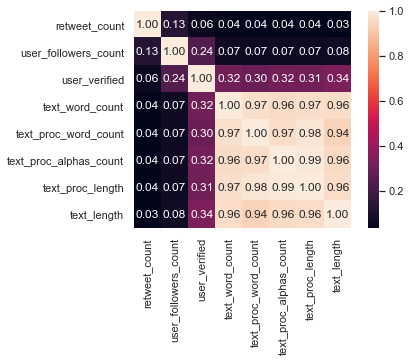

In [162]:
correlation = df_train_text.corr(method='pearson')
columns = correlation.nlargest(8, 'retweet_count').index

correlation_map = np.corrcoef(df_train_text[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

In [163]:
df_train_text.columns

Index(['timestamp', 'retweet_count', 'user_verified', 'user_statuses_count',
       'user_followers_count', 'user_friends_count', 'user_mentions', 'urls',
       'hashtags', 'fuck', 'shit', 't.co', 'covid', 'coronavirus',
       'text_length', 'text_proc_length', 'text_proc_length_to_text_length',
       'text_lines_count', 'text_word_count', 'text_proc_word_count',
       'text_proc_word_count_to_text_word_count', 'text_mean_word_length',
       'text_proc_mean_word_length',
       'text_proc_mean_word_length_to_text_mean_word_length',
       'text_proc_alphas_count', 'text_alphas_count',
       'text_proc_alphas_count_to_text_alphas_count', 'text_alphas_percent',
       'text_non_alphas_count', 'text_digits_count', 'text_emoji_count',
       'text_emoji_percent', 'text_has_emoji', 'text_upper_letter_count',
       'text_upper_letter_count_to_word_count',
       'text_upper_letter_count_to_length', 'text_urls_count',
       'text_urls_count_to_words_count', 'text_hashtags_count',
    

In [136]:
df_train_text.replace([np.inf, -np.inf], np.nan)
df_train_text = df_train_text.fillna(0)

In [172]:
distilledDATA = pd.DataFrame()
distilledDATA["retweet_count"] = df_train_text["retweet_count"]
distilledDATA["user_followers_count"] = df_train_text["user_followers_count"]
distilledDATA["user_friends_count"] = df_train_text["user_friends_count"]
distilledDATA["user_mentions"] = df_train_text["user_mentions"]
distilledDATA["user_verified"] = df_train_text["user_verified"]
distilledDATA["text_word_count"] = df_train_text["text_word_count"]
distilledDATA["text_proc_word_count"] = df_train_text["text_proc_word_count"]
distilledDATA["text_proc_alphas_count"] = df_train_text["text_proc_alphas_count"]
distilledDATA["text_proc_length"] = df_train_text["text_proc_length"]
distilledDATA["text_length"] = df_train_text["text_length"]
distilledDATA["text_alphas_count"] = df_train_text["text_alphas_count"]
distilledDATA["text_non_alphas_count"] = df_train_text["text_non_alphas_count"]

distilledDATA["time_day"] = df_train_text["time_day"]
distilledDATA["time_hour"] = df_train_text["time_hour"]
distilledDATA["time_day"] = df_train_text["time_day"]


In [173]:
print(np.where(np.isnan(distilledDATA)))
print(np.isnan(distilledDATA.values.any()))

(array([], dtype=int64), array([], dtype=int64))
False


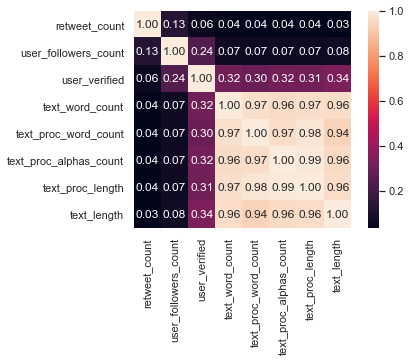

In [174]:
correlation = distilledDATA.corr(method='pearson')
columns = correlation.nlargest(8, 'retweet_count').index

correlation_map = np.corrcoef(distilledDATA[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

In [206]:
#### Splitting dataset
from verstack.stratified_continuous_split import scsplit # pip install verstack

X_train, X_test, y_train, y_test = scsplit(distilledDATA, distilledDATA['retweet_count'], stratify=distilledDATA['retweet_count'], train_size=0.7, test_size=0.3, random_state=42)

In [207]:
from sklearn.model_selection import train_test_split

# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_train, X_train['retweet_count'], \
                                                  test_size=0.1, random_state=21)

In [208]:
# We remove the actual number of retweets from our features since it is the value that we are trying to predict
X_train = X_train.drop(['retweet_count'], axis=1)
X_val = X_val.drop(['retweet_count'], axis=1)
X_test = X_test.drop(['retweet_count'], axis=1)

In [209]:
print("\t Train dataset shape: ", X_train.shape)
print("\t Val dataset shape: ", X_val.shape)
print("-----------------------------------------------------")
print("\t Y_train dataset shape: ", y_train.shape)
print("\t Y_val dataset shape: ", y_val.shape)
print("-----------------------------------------------------")
print("\t X_Test dataset shape: ", X_test.shape)
print("\t Y_test dataset shape: ", y_test.shape)

	 Train dataset shape:  (418443, 13)
	 Val dataset shape:  (46494, 13)
-----------------------------------------------------
	 Y_train dataset shape:  (418443,)
	 Y_val dataset shape:  (46494,)
-----------------------------------------------------
	 X_Test dataset shape:  (199260, 13)
	 Y_test dataset shape:  (199260,)


In [210]:
print(np.isnan(X_train.values.any()))
print(np.isnan(X_val.values.any()))
print(np.isnan(X_test.values.any()))

False
False
False


In [199]:
#lr_X_train.drop('shit', axis=1, inplace=True)
#lr_X_train.drop('fuck', axis=1, inplace=True)
#lr_X_train.drop('t.co', axis=1, inplace=True)
#lr_X_train.drop('covid', axis=1, inplace=True)
#lr_X_train.drop('coronavirus', axis=1, inplace=True)
#lr_X_train.drop('user_verified', axis=1, inplace=True)

In [200]:
"""
lr_X_train = pd.DataFrame()
lr_X_train["user_verified"] = lr_X_train["user_verified"]
lr_X_train["user_followers_count"] = lr_X_train["user_followers_count"]
lr_X_train["user_friends_count"] = lr_X_train["user_friends_count"]
lr_X_train["user_mentions"] = lr_X_train["user_mentions"]
lr_X_train["urls"] = lr_X_train["urls"]

lr_X_test = pd.DataFrame()
lr_X_test["user_verified"] = X_test["user_verified"]
lr_X_test["user_followers_count"] = X_test["user_followers_count"]
lr_X_test["user_friends_count"] = X_test["user_friends_count"]
lr_X_test["user_mentions"] = X_test["user_mentions"]
lr_X_test["urls"] = X_test["urls"]
"""

'\nlr_X_train = pd.DataFrame()\nlr_X_train["user_verified"] = lr_X_train["user_verified"]\nlr_X_train["user_followers_count"] = lr_X_train["user_followers_count"]\nlr_X_train["user_friends_count"] = lr_X_train["user_friends_count"]\nlr_X_train["user_mentions"] = lr_X_train["user_mentions"]\nlr_X_train["urls"] = lr_X_train["urls"]\n\nlr_X_test = pd.DataFrame()\nlr_X_test["user_verified"] = X_test["user_verified"]\nlr_X_test["user_followers_count"] = X_test["user_followers_count"]\nlr_X_test["user_friends_count"] = X_test["user_friends_count"]\nlr_X_test["user_mentions"] = X_test["user_mentions"]\nlr_X_test["urls"] = X_test["urls"]\n'

In [211]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [212]:
scaler = MinMaxScaler()
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [213]:
type(X_train)

numpy.ndarray

In [214]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [215]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

In [312]:
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.01
NUM_FEATURES = X_train.shape[1]

In [313]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [314]:
class Regression(nn.Module):
    def __init__(self, num_features):
        super(Regression, self).__init__()
        
        self.layer_1 = nn.Linear(num_features, 128)
        self.layer_2 = nn.Linear(128, 128)
        self.layer_3 = nn.Linear(128, 128)
        #self.layer_4 = nn.Linear(32, 28)
        #self.layer_5 = nn.Linear(28, 8)
        self.layer_out = nn.Linear(128, 1)
        
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        #x = self.relu(self.layer_4(x))
        #x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return (x)
    
    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        #x = self.relu(self.layer_4(x))
        #x = self.relu(self.layer_5(x))
        x = self.layer_out(x)
        return (x)

In [315]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [317]:
model = Regression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Regression(
  (layer_1): Linear(in_features=13, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=128, bias=True)
  (layer_3): Linear(in_features=128, out_features=128, bias=True)
  (layer_out): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


In [318]:
loss_stats = {
    'train': [],
    "val": []
}

In [ ]:
for e in range(1, EPOCHS+1):
    # TRAINING
    train_epoch_loss = 0
    train_epoch_loss_mae = 0
    
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        loss_mae = nn.L1Loss()(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        train_epoch_loss_mae += loss_mae.item()
        
    # VALIDATION    
    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_mae = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            mae_loss = nn.L1Loss()(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
            val_epoch_mae += mae_loss.item()
            
    loss_stats['train'].append(train_epoch_loss/len(train_loader))
    loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')
    print(f'\t   | MAE Train Loss: {train_epoch_loss_mae:.5f} | MAE Val Loss: {val_epoch_mae:.5f}')

In [223]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [224]:
min(y_pred_list), max(y_pred_list)

(-7.857892342144623e-05, 48154.671875)

In [225]:
mapped = y_pred_list.copy()

In [227]:
for i, val in enumerate(mapped):
    if val < 0:
        mapped[i] = 0

In [228]:
min(mapped), max(mapped)

(0, 48154.671875)

In [231]:
sum(mapped)/len(mapped)

14.00003743249906

In [232]:
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test, mapped)
mae = mean_absolute_error(y_test, mapped)
print("\t Mean Squared Error :", mse)
print("\t mean_absolute_error :", mae)

	 Mean Squared Error : 11928723.75346459
	 mean_absolute_error : 143.54084362468322


In [252]:
#### Checking on zero score
print("\t mean_absolute_error :", mean_absolute_error(y_test, np.zeros(len(mapped))))

	 mean_absolute_error : 148.3304476563284


In [233]:
PATH = "NN_BestNumFeatures" + str(EPOCHS) + "_epochs_" + str(int(mae)) + ".pt"
torch.save(model.state_dict(), PATH)

In [235]:
path = os.getcwd()
path_data_eval = path + "\\covidChallenge\\data\\evaluation.csv"
evaluation = pd.read_csv(path_data_eval)

In [243]:
evaluation['urls'] = evaluation['text'].apply(lambda s: len(re.findall(r'http(\S)+', s)))
evaluation['hashtags'] = evaluation['text'].apply(lambda s: len(re.findall(r'#[a-zA-Z]+', s)))
evaluation['user_mentions'] = evaluation['text'].apply(lambda s: len(re.findall(r'@[a-zA-Z_]+', s)))

In [249]:
evaluation.columns

Index(['id', 'timestamp', 'user_verified', 'user_statuses_count',
       'user_followers_count', 'user_friends_count', 'user_mentions', 'urls',
       'hashtags', 'text'],
      dtype='object')

In [250]:
extendedVal = add_text_features(evaluation)

In [251]:
# df_train_text = add_timestamp_features(df_train_text)
extendedVal = add_timestamp_features(extendedVal)

In [253]:
extendedVal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285334 entries, 0 to 285333
Data columns (total 51 columns):
 #   Column                                               Non-Null Count   Dtype         
---  ------                                               --------------   -----         
 0   id                                                   285334 non-null  int64         
 1   timestamp                                            285334 non-null  int64         
 2   user_verified                                        285334 non-null  bool          
 3   user_statuses_count                                  285334 non-null  int64         
 4   user_followers_count                                 285334 non-null  int64         
 5   user_friends_count                                   285334 non-null  int64         
 6   user_mentions                                        285334 non-null  int64         
 7   urls                                                 285334 non-null  int6

In [255]:
distilledEval = pd.DataFrame()
distilledEval["user_followers_count"] = extendedVal["user_followers_count"]
distilledEval["user_friends_count"] = extendedVal["user_friends_count"]
distilledEval["user_mentions"] = extendedVal["user_mentions"]
distilledEval["user_verified"] = extendedVal["user_verified"]
distilledEval["text_word_count"] = extendedVal["text_word_count"]
distilledEval["text_proc_word_count"] = extendedVal["text_proc_word_count"]
distilledEval["text_proc_alphas_count"] = extendedVal["text_proc_alphas_count"]
distilledEval["text_proc_length"] = extendedVal["text_proc_length"]
distilledEval["text_length"] = extendedVal["text_length"]
distilledEval["text_alphas_count"] = extendedVal["text_alphas_count"]
distilledEval["text_non_alphas_count"] = extendedVal["text_non_alphas_count"]

distilledEval["time_day"] = extendedVal["time_day"]
distilledEval["time_hour"] = extendedVal["time_hour"]
distilledEval["time_day"] = extendedVal["time_day"]


In [256]:
distilledEval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285334 entries, 0 to 285333
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype
---  ------                  --------------   -----
 0   user_followers_count    285334 non-null  int64
 1   user_friends_count      285334 non-null  int64
 2   user_mentions           285334 non-null  int64
 3   user_verified           285334 non-null  bool 
 4   text_word_count         285334 non-null  int64
 5   text_proc_word_count    285334 non-null  int64
 6   text_proc_alphas_count  285334 non-null  int64
 7   text_proc_length        285334 non-null  int64
 8   text_length             285334 non-null  int64
 9   text_alphas_count       285334 non-null  int64
 10  text_non_alphas_count   285334 non-null  int64
 11  time_day                285334 non-null  int64
 12  time_hour               285334 non-null  int64
dtypes: bool(1), int64(12)
memory usage: 26.4 MB


In [272]:
distilledEval = distilledEval.astype(float)

In [273]:
class EvaluationDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [278]:
distilledEval

array([[3.600000e+01, 9.900000e+01, 0.000000e+00, ..., 2.400000e+01,
        5.000000e+00, 4.000000e+00],
       [4.127300e+04, 3.260000e+02, 0.000000e+00, ..., 4.000000e+00,
        3.000000e+00, 1.000000e+00],
       [3.450000e+02, 2.000000e+02, 0.000000e+00, ..., 2.800000e+01,
        4.000000e+00, 5.000000e+00],
       ...,
       [7.700000e+01, 2.100000e+02, 0.000000e+00, ..., 4.000000e+00,
        4.000000e+00, 1.000000e+00],
       [9.742490e+05, 3.400000e+02, 0.000000e+00, ..., 2.100000e+01,
        5.000000e+00, 7.000000e+00],
       [1.106541e+06, 3.810000e+02, 0.000000e+00, ..., 8.000000e+00,
        4.000000e+00, 9.000000e+00]])

In [282]:
distilledEval = np.array(distilledEval)
eval_dataset = EvaluationDataset(torch.from_numpy(distilledEval).float())
eval_loader = DataLoader(dataset=eval_dataset, batch_size=1)

In [294]:
distilledEval_scaled = scaler.transform(distilledEval)

In [301]:
distilledEval_scaled = np.array(distilledEval_scaled)
eval_dataset_scaled = EvaluationDataset(torch.from_numpy(distilledEval_scaled).float())
eval_loader_scaled = DataLoader(dataset=eval_dataset_scaled, batch_size=1)

In [283]:
device

device(type='cuda', index=0)

In [284]:
eval_list = []
with torch.no_grad():
    model.eval()
    for X_batch in eval_loader:
        X_batch = X_batch.to(device)
        #X_batch = X_batch
        y_test_pred = model(X_batch)
        eval_list.append(y_test_pred.cpu().numpy())
        
eval_list = [a.squeeze().tolist() for a in eval_list]

In [302]:
eval_list_scaled = []
with torch.no_grad():
    model.eval()
    for X_batch in eval_loader_scaled:
        X_batch = X_batch.to(device)
        #X_batch = X_batch
        y_test_pred = model(X_batch)
        eval_list_scaled.append(y_test_pred.cpu().numpy())
        
eval_list_scaled = [a.squeeze().tolist() for a in eval_list_scaled]

In [285]:
min(eval_list), max(eval_list)

(-7.857892342144623e-05, 137564897280.0)

In [303]:
min(eval_list_scaled), max(eval_list_scaled)

(-7.857892342144623e-05, 50204.1953125)

In [286]:
output = eval_list.copy()
for i, val in enumerate(output):
    if val < 0:
        output[i] = 0

In [304]:
output_scaled = eval_list_scaled.copy()
for i, val in enumerate(output_scaled):
    if val < 0:
        output_scaled[i] = 0

In [291]:
counter = 0
for i, val in enumerate(output):
    if val == 0:
        counter += 1
print(counter)

31121


In [305]:
counter = 0
for i, val in enumerate(output_scaled):
    if val == 0:
        counter += 1
print(counter)

198996


In [293]:
sum(output) / len(output)

270324891.7725849

In [306]:
sum(output_scaled) / len(output_scaled)

14.384038105226077

In [308]:
sum(output_scaled)

4104255.1287165773

In [309]:
import csv

f = open("NN_NumFeatsLast.csv", "w+")
with open("NN_NumFeatsLast.csv", 'w') as f:
    writer = csv.writer(f)
    writer.writerow(["TweetID", "NoRetweets"])
    
    startIndex = 665776
    for index, prediction in enumerate(output_scaled):
        print(str(evaluation['id'].iloc[index]) + " ," + str(int(prediction)))
        writer.writerow([str(startIndex + index) , str(int(prediction))])

665776 ,0
665777 ,0
665778 ,0
665779 ,40
665780 ,0
665781 ,0
665782 ,0
665783 ,7
665784 ,22
665785 ,62
665786 ,60
665787 ,0
665788 ,0
665789 ,44
665790 ,0
665791 ,3
665792 ,3
665793 ,3
665794 ,5
665795 ,0
665796 ,2
665797 ,1
665798 ,48
665799 ,0
665800 ,0
665801 ,0
665802 ,0
665803 ,43
665804 ,0
665805 ,5
665806 ,0
665807 ,3
665808 ,29
665809 ,0
665810 ,0
665811 ,59
665812 ,0
665813 ,0
665814 ,1
665815 ,0
665816 ,0
665817 ,0
665818 ,0
665819 ,0
665820 ,0
665821 ,0
665822 ,0
665823 ,0
665824 ,0
665825 ,8
665826 ,66
665827 ,0
665828 ,162
665829 ,0
665830 ,0
665831 ,0
665832 ,0
665833 ,0
665834 ,0
665835 ,0
665836 ,0
665837 ,0
665838 ,29
665839 ,0
665840 ,0
665841 ,0
665842 ,0
665843 ,0
665844 ,0
665845 ,0
665846 ,55
665847 ,0
665848 ,3
665849 ,6
665850 ,0
665851 ,1
665852 ,0
665853 ,0
665854 ,0
665855 ,0
665856 ,43
665857 ,0
665858 ,0
665859 ,27
665860 ,74
665861 ,0
665862 ,0
665863 ,0
665864 ,94
665865 ,0
665866 ,5
665867 ,0
665868 ,0
665869 ,0
665870 ,0
665871 ,7
665872 ,2
665873 ,4
66